# Task Details:

## About:

1) Like X-ray, Sonar and ecolocation, Reflection Seismology collects seismic data by recording reflections from the rock interfaces within the subsurfaces.

2) Seismic image shows the reflection coming from rock boundaries.

3) The strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface.

4) The aim of this task is to identify salt within the subsurface.

5) Salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt.

6) Salt has a density which is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of Salt is 4.5 km/sec, which is usually faster than its surrounding rocks.

7) Reflectivity from salt is not much unless there are sediments trapped inside it.

## Data:

1) The data is a set of images chosen at various locations chosen at random in the subsurface. 

2) Resolution of each training image is 101x101x3.

3) Corresponding output of each image is a mask where each pixel is marked either as Salt or Sediment.

4) There are a total of 4000 images and their corresponding masks in the training set. 

5) Test set consists of 18000 images for which salt segmentation has to be done.

6) In addition to the images, the depths(in feet) of the images are also give.


## Approach:
1) Data Exploration and Analysis.

2) Writing a Unet model.

3) Stratified K-fold Training.

4) Plotting Training Accuracy and Validation Accuracy. 

5) Result 






# Step 1: Data Exploration and Analysis

In [1]:
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [2]:
depth = pd.read_csv("data/depths.csv", index_col="id")
train = pd.read_csv("data/train/train.csv", index_col="id")
train = train.join(depth)
test = depth[~depth.index.isin(train.index)]

### The images can be analyzed and grouped based on the following:
    
    1) Depth of the image
    
    2) Area of Salt Coverage

### 1) Depth of the image:

The following plot shows that the depth of the image varies from 50 - 950. With mean value around 500 and standard deviation of around 300.

Using this we can group the training and test set into 5 categories as images taken at a depth of 0-200, 200-400, 400-600, 600-800, 800-1000.  

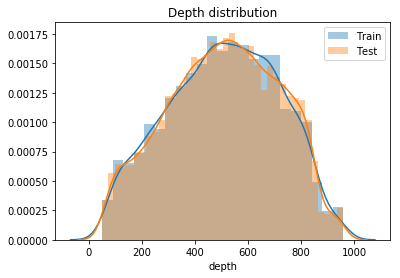

In [3]:
train_depth = sns.distplot(train.z, label="Train")
test_depth = sns.distplot(test.z, label="Test")
train_depth.set(xlabel='depth')
legend = plt.legend()
title = plt.title("Depth distribution")

In [4]:
train['depth_category'] = (train.z/200).astype(int)
test['depth_category'] = (test.z/200).astype(int)

/home/janu/ENVS/raybaby/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### 2) Area of salt Coverage:

The following plot shows that the area of salt_coverage of the image varies from 0 - 30000 pixels.

Using this we can group the training and test set into 6 categories.

In [5]:
train['salt_coverage'] = pd.Series(0, index=train.index)
for id in train.index:
    train['salt_coverage'][id] = np.sum(cv2.imread("data/train/masks/"+str(id)+".png")/255)

/home/janu/ENVS/raybaby/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


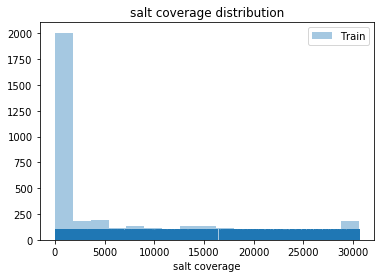

In [6]:
train_depth = sns.distplot(train.salt_coverage, label="Train", kde=False, rug=True)
train_depth.set(xlabel='salt coverage')
legend = plt.legend()
title = plt.title("salt coverage distribution")

In [7]:
train['salt_coverage_category'] = (train.salt_coverage/5000).astype(int)

## Step 2: Unet Model

In [16]:
def get_unet_128(input_shape=(128, 128, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 128
    down1 = Conv2D(64, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer="adam",loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [17]:
input_size = 128
epochs = 300
batch_size = 16
threshold = 0.7

In [18]:
callbacks = [EarlyStopping(patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(filepath='salt_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='logs')]

In [19]:
from keras.models import load_model
model = get_unet_128()
model.load_weights(filepath='salt_weights.hdf5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 128, 128, 64) 256         conv2d_24[0][0]                  
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 128, 128, 64) 0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
conv2d_25 

## Step 3: Stratified K-fold Training

In [20]:
def image_generator(image_index):
    x_batch = []
    y_batch = []
    for id in image_index:
        img = cv2.imread('data/train/images/{}.png'.format(train.index[id]))
        #depth_value = train.z[id]
        input_size = 128
        img = cv2.resize(img, (input_size, input_size))
        #depth_column =  np.asarray([depth_value]*381)
        #depth_column = depth_column.reshape(127,1,3)
        #depth_row =  np.asarray([depth_value]*384)
        #depth_row = depth_row.reshape(1,128,3)
        #img = np.column_stack([img,depth_column])
        #img = np.row_stack([img,depth_row])
        mask = cv2.imread('data/train/masks/{}.png'.format(train.index[id]), cv2.IMREAD_GRAYSCALE)
        input_size = 128
        mask = cv2.resize(mask, (input_size, input_size))
        mask = np.expand_dims(mask, axis=2)
        x_batch.append(img)
        y_batch.append(mask)
    x_batch = np.array(x_batch, np.float32) / 255
    y_batch = np.array(y_batch, np.float32) / 255
    return x_batch, y_batch

In [21]:
def test_image_generator(image_index):
    x_batch = []
    for id in image_index:
        img = cv2.imread('data/test/images/{}.png'.format(id))
        #depth_value = test.z.id
        input_size = 128
        img = cv2.resize(img, (input_size, input_size))
        #depth_column =  np.asarray([depth_value]*381)
        #depth_column = depth_column.reshape(127,1,3)
        #depth_row =  np.asarray([depth_value]*384)
        #depth_row = depth_row.reshape(1,128,3)
        #img = np.column_stack([img,depth_column])
        #img = np.row_stack([img,depth_row])
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    return x_batch

In [22]:
def test_image_retriever(test_images,original_size):
    batch = []
    for image in test_images:
        img = cv2.resize(image, (original_size, original_size))
        batch.append(img)
    return batch

split Number: 1
Number of images in training set: 3198
Number of images in validation set: 802
Train on 3198 samples, validate on 802 samples
Epoch 1/300
3198/3198 [==============================] - 4837s 2s/step - loss: 0.1457 - acc: 0.9398 - val_loss: 0.2632 - val_acc: 0.9002
Epoch 2/300
3198/3198 [==============================] - 4535s 1s/step - loss: 0.1421 - acc: 0.9421 - val_loss: 0.3168 - val_acc: 0.8990
Epoch 3/300
3198/3198 [==============================] - 4382s 1s/step - loss: 0.1372 - acc: 0.9451 - val_loss: 0.1591 - val_acc: 0.9364
Epoch 4/300
3198/3198 [==============================] - 4712s 1s/step - loss: 0.1314 - acc: 0.9449 - val_loss: 0.1519 - val_acc: 0.9367
Epoch 5/300
3198/3198 [==============================] - 4470s 1s/step - loss: 0.1229 - acc: 0.9490 - val_loss: 0.2363 - val_acc: 0.9090
Epoch 6/300
3198/3198 [==============================] - 4656s 1s/step - loss: 0.1232 - acc: 0.9478 - val_loss: 0.1523 - val_acc: 0.9396
Epoch 7/300
3198/3198 [=============

3202/3202 [==============================] - 4252s 1s/step - loss: 0.0841 - acc: 0.9662 - val_loss: 0.0536 - val_acc: 0.9760

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.00000008274e-12.
Epoch 00012: early stopping
split Number: 5
Number of images in training set: 3202
Number of images in validation set: 798
Train on 3202 samples, validate on 798 samples
Epoch 1/300
3202/3202 [==============================] - 4253s 1s/step - loss: 0.0859 - acc: 0.9654 - val_loss: 0.0508 - val_acc: 0.9772
Epoch 2/300
3202/3202 [==============================] - 4625s 1s/step - loss: 0.0874 - acc: 0.9649 - val_loss: 0.0508 - val_acc: 0.9772
Epoch 3/300
3202/3202 [==============================] - 4796s 1s/step - loss: 0.0839 - acc: 0.9658 - val_loss: 0.0508 - val_acc: 0.9771
Epoch 4/300
3202/3202 [==============================] - 4342s 1s/step - loss: 0.0844 - acc: 0.9659 - val_loss: 0.0509 - val_acc: 0.9772
Epoch 5/300
3202/3202 [==============================] - 4359s 1s/step - loss: 0

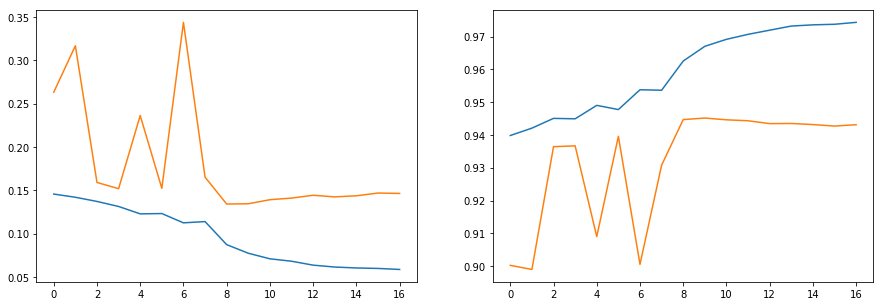

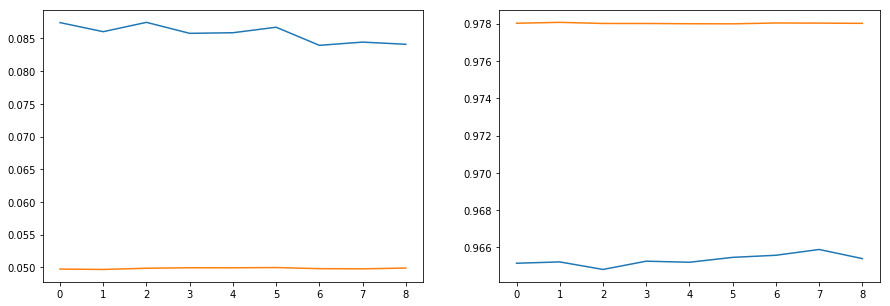

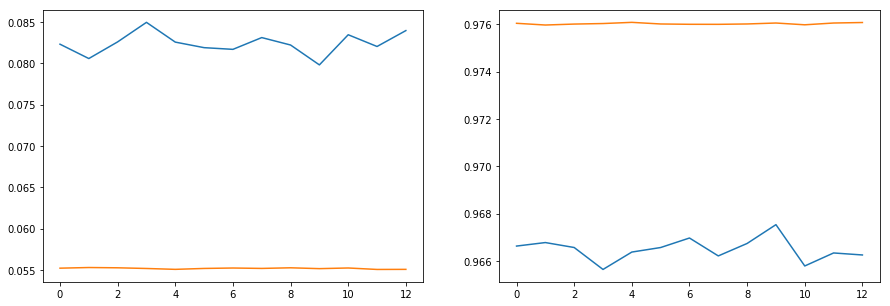

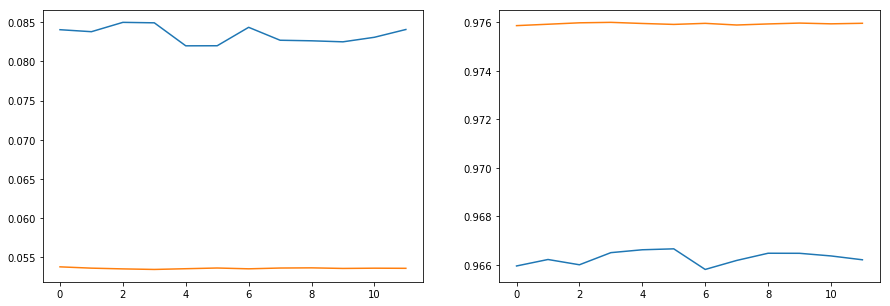

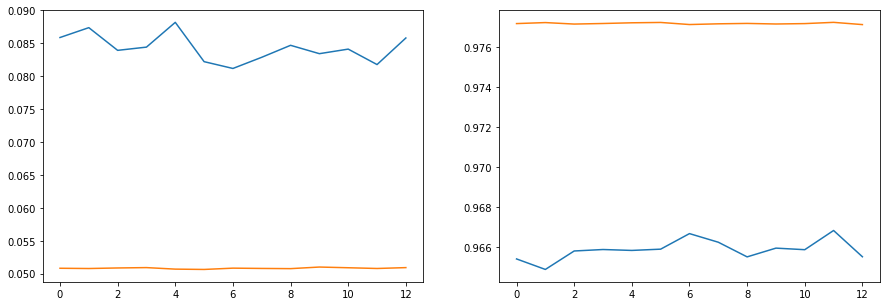

In [23]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
counter = 0
for train_ids, valid_ids in skf.split(train.index, train.depth_category):
    counter+=1
    print "split Number:",counter
    print "Number of images in training set:",len(train_ids)
    print "Number of images in validation set:",len(valid_ids)
    x_train,y_train = image_generator(train_ids)
    x_valid,y_valid = image_generator(valid_ids)
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)
    fig, (loss, acc) = plt.subplots(1, 2, figsize=(15,5))
    loss.plot(history.epoch, history.history["loss"], label="Train loss")
    loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
    acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [24]:
model.get_weights()

[array([[[[-0.14671426,  0.025005  , -0.09286109, ...,  0.11961465,
           -0.00202065, -0.03360173],
          [-0.05367174, -0.07001751, -0.10957761, ...,  0.00862372,
           -0.07817803,  0.10687216],
          [-0.13790204, -0.06984762, -0.12533426, ...,  0.07833449,
           -0.06774957,  0.07560145]],
 
         [[ 0.11825456,  0.12396682, -0.05684957, ...,  0.03938255,
           -0.05956699, -0.09606428],
          [-0.05305854, -0.00865919, -0.07540671, ...,  0.08862227,
            0.02255384, -0.16049449],
          [ 0.07916823,  0.12897018, -0.02896565, ..., -0.05870449,
            0.05223953, -0.13732834]],
 
         [[ 0.12610157,  0.17693694, -0.1591483 , ..., -0.11676475,
            0.00239745, -0.1534466 ],
          [ 0.12768029,  0.15881373, -0.08014403, ..., -0.1127246 ,
           -0.08902664,  0.01484112],
          [ 0.11499284,  0.09108102, -0.04935632, ..., -0.06379327,
           -0.06815979, -0.16506593]]],
 
 
        [[[ 0.03560865, -0.1174118

In [25]:
x_test = test_image_generator(test.index)

In [1]:
preds_test = model.predict(x_test).reshape(-1,input_size, input_size)


NameError: name 'model' is not defined

In [87]:
preds_test = test_image_retriever(preds_test,101)

In [88]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [92]:
from tqdm import tqdm_notebook
pred_dict = {idx: RLenc(np.round(preds_test[i] > 0.5)) for i, idx in enumerate(tqdm_notebook(test.index.values))}

In [94]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')